In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import torch
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ml_confs
from tqdm import tqdm

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

from NCP.cde_fork.density_simulation import LinearGaussian, ArmaJump, SkewNormal, EconDensity, GaussianMixture, JumpDiffusionModel
from NCP.cde_fork.model_fitting.divergences import kl_divergence_pdf

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)  

np.random.seed(42)
torch.manual_seed(42)
Ntrain = 10000
Nval = 1000
Ntest = 100

# torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'

cuda:0


In [21]:
from sklearn.neighbors import KernelDensity
from scipy.special import rel_entr

class empirical_marginal(KernelDensity):
    def __call__(self, x):
        log_probability = self.score_samples(np.array(x).reshape(-1, 1))
        probability = np.exp(log_probability)
        return probability

def pdf2cdf(pdf, step):
    return np.cumsum(pdf * step)

def normalize(x):
    return x/x.sum()

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = get_pdf(model, x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        # true_pdf = density_simulator.pdf(x, yscaler.inverse_transform(y).T)
        true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform(x[..., None]), scale=sigma_sq)
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

def KL(p, q):
    eps = np.finfo(p.dtype).eps
    p = np.where(p < eps, eps, p)
    q = np.where(q < eps, eps, q)
    
    p = normalize(p)
    q = normalize(q)
    
    return np.sum(rel_entr(p, q))

## Linear gaussian

In [5]:
X = np.random.normal(0, 1, Ntrain+Nval+Ntest)
from math import sqrt
sigma_sq = .5
Y = X + np.random.normal(0, sigma_sq, X.shape[0])

p_x = lambda x: (1/sqrt(2*np.pi)) * np.exp(-(x**2)/2)
p_y = lambda y: (1/(sqrt(2*np.pi)*sqrt(1+sigma_sq))) * np.exp(-(y**2)/(2*(1+sigma_sq)))

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

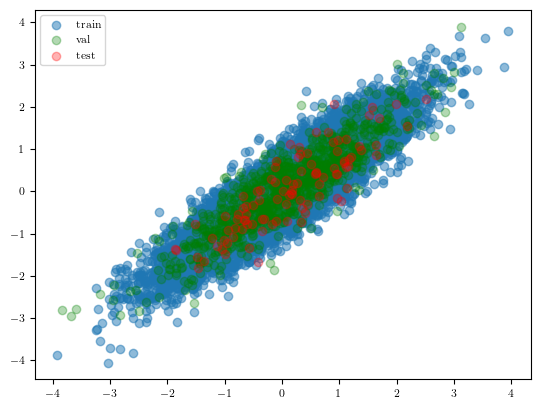

In [6]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [7]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 1,
    'layer_size': 512,
    'lr': 1e-3,
    'gamma': 1e-3,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)

In [8]:
model.models

ModuleDict(
  (U): MLPOperator(
    (model): Sequential(
      (0): MLPBlock(
        (linear): Linear(in_features=1, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (relu): ReLU()
      )
      (1): Linear(in_features=512, out_features=100, bias=False)
    )
  )
  (S): SingularLayer()
  (V): MLPOperator(
    (model): Sequential(
      (0): MLPBlock(
        (linear): Linear(in_features=1, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (relu): ReLU()
      )
      (1): Linear(in_features=512, out_features=100, bias=False)
    )
  )
)

In [9]:
model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -2.871004343032837: 100%|██████████| 2000/2000 [00:28<00:00, 69.15it/s] 


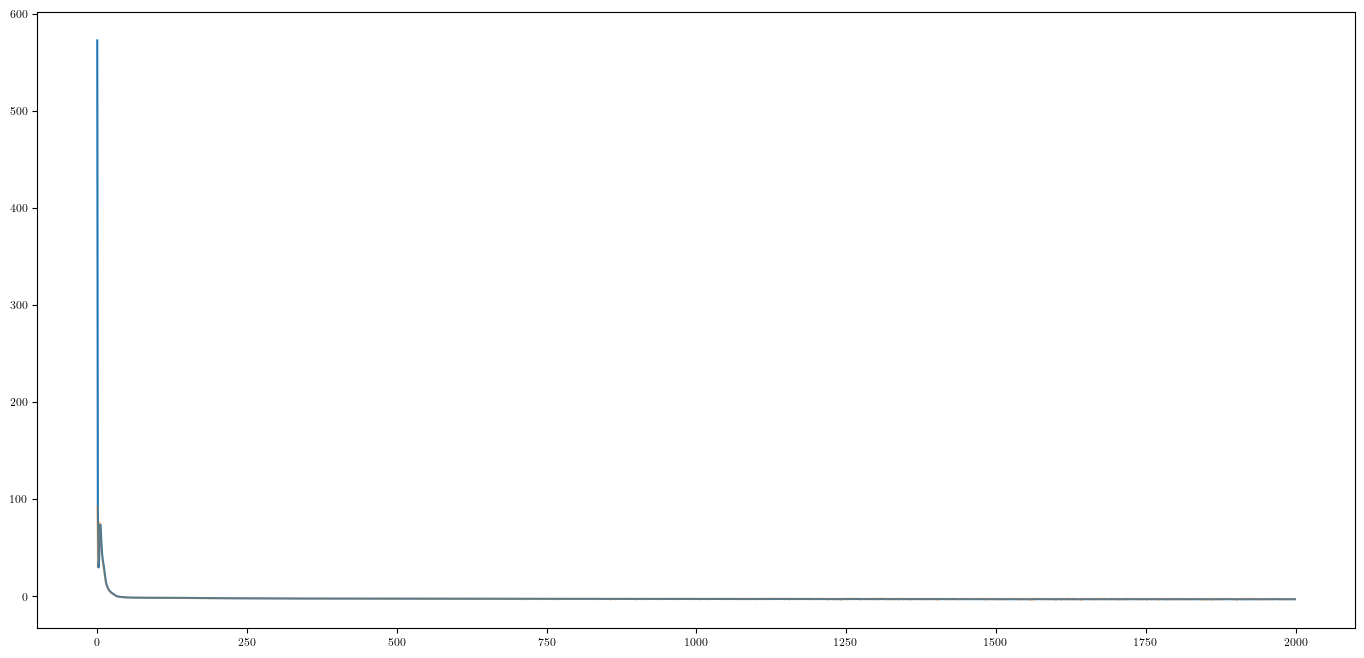

In [10]:
ls = model.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(model.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

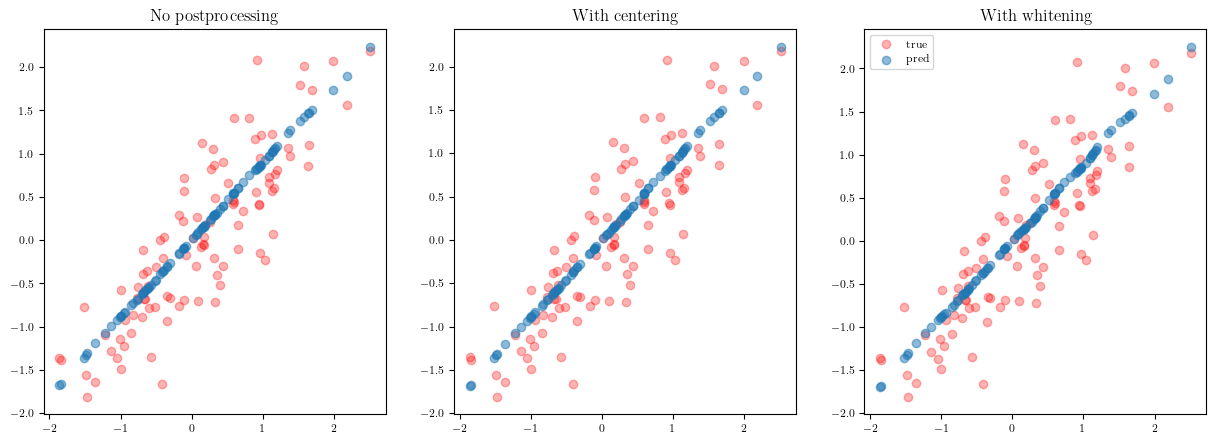

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = model.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = model.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = model.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

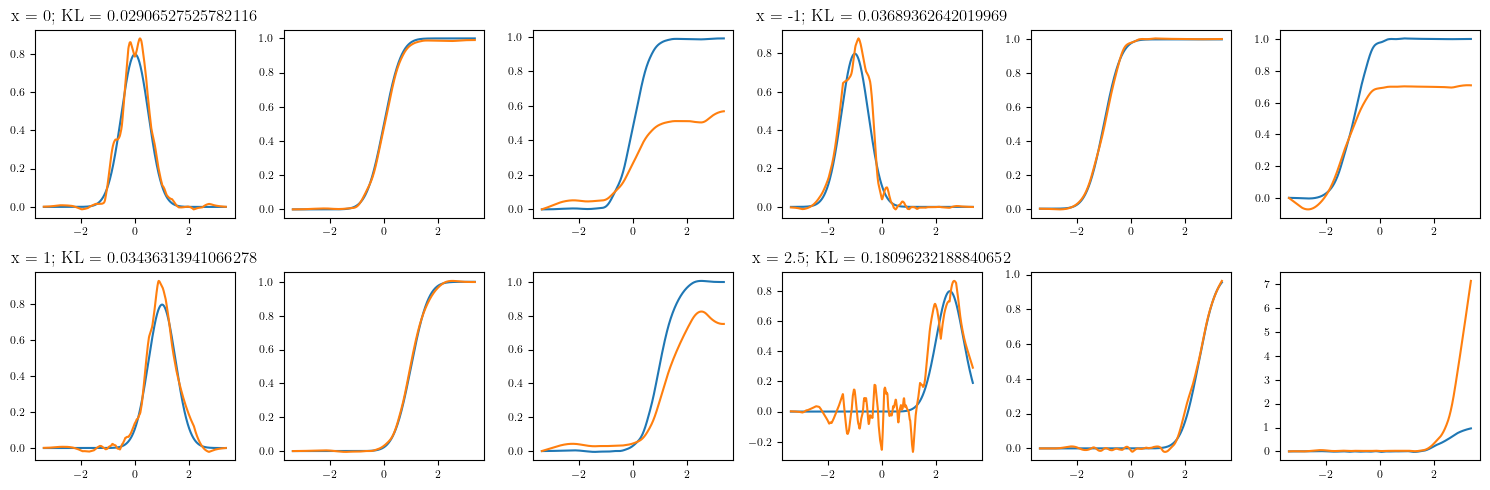

In [12]:
from scipy.stats import norm
from NCP.cdf import get_pdf, get_cdf, compute_marginal
from NCP.metrics import *

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = ys.reshape(-1, 1)

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15,5))
axes = ax.flatten()

for i, xi in enumerate([0, -1, 1, 2.5]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = get_pdf(model, x_scaled, ys, postprocess='whitening', p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = norm.pdf(fys, loc=xi, scale=sigma_sq)
    axes[i*3].plot(fys, true_pdf)
    axes[i*3].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    _, pred_cdf2 = get_cdf(model, x_scaled, ys, postprocess='whitening')
    true_cdf = norm.cdf(fys, loc=xi, scale=sigma_sq)
    axes[i*3+1].plot(fys, true_cdf)
    axes[i*3+1].plot(fys, pred_cdf)
    axes[i*3+2].plot(fys, pred_cdf)
    axes[i*3+2].plot(fys, pred_cdf2)

    axes[i*3].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_pdf, pred_pdf)))
    # axes[i*2+1].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_cdf, pred_cdf)))

plt.tight_layout()
plt.show()

In [13]:
scores = empirical_KL(model, X_test, np.linspace(-2.5, 2.5, num=100).reshape(-1, 1))

100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


In [14]:
print(np.mean(scores))
print(np.median(scores))

0.029504001265966
0.02374547217871821


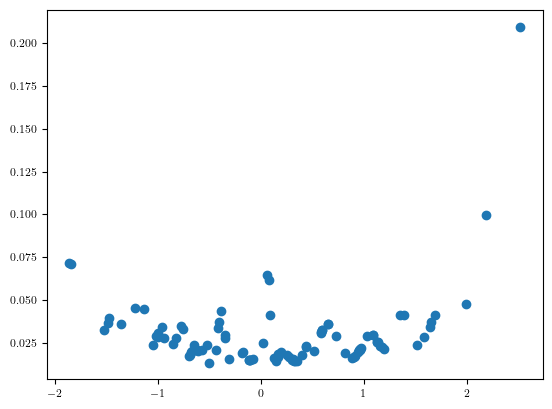

In [22]:
plt.scatter(X_test.squeeze(), np.array(scores))

In [24]:
KL(true_pdf, pred_pdf)

0.3042655945032021

In [25]:
kullback_leibler(true_cdf, pred_cdf, fys)

0.5098634553886615

## ECON 

In [42]:
sigma_sq = 1
density_simulator = EconDensity(std= sigma_sq, heteroscedastic=True, random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

# p_x = lambda x: (2/np.sqrt(2*np.pi)) * np.exp(-(x**2)/2) if x > 0 else 0
# def p_x(x):
#     px = (2/np.sqrt(2*np.pi)) * np.exp(-(x**2)/2)
#     px[x<0] = 0 
#     return px
# 
# p_y = lambda y: (1/np.sqrt(2*np.pi)) * np.exp(-(y)/2) * (1/np.sqrt(2*np.pi*sigma_sq)) * np.exp(-(y**2)/(2*sigma_sq))

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = get_pdf(model, x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = density_simulator.pdf(xscaler.inverse_transform(x[..., None]), fys.reshape(1, -1))
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

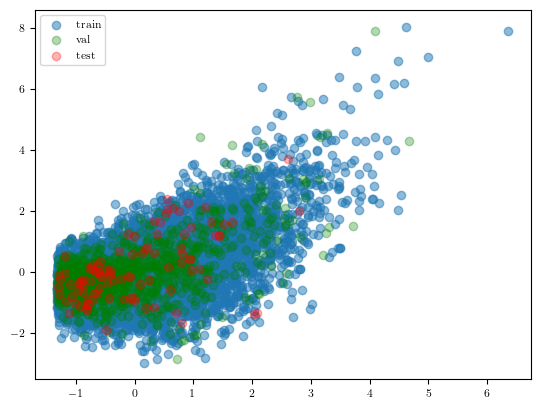

In [16]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [28]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 1,
    'layer_size': 64,
    'lr': 1e-4,
    'gamma': 1e-3,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)

In [29]:
model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -0.6989961266517639: 100%|██████████| 2000/2000 [00:22<00:00, 90.46it/s]


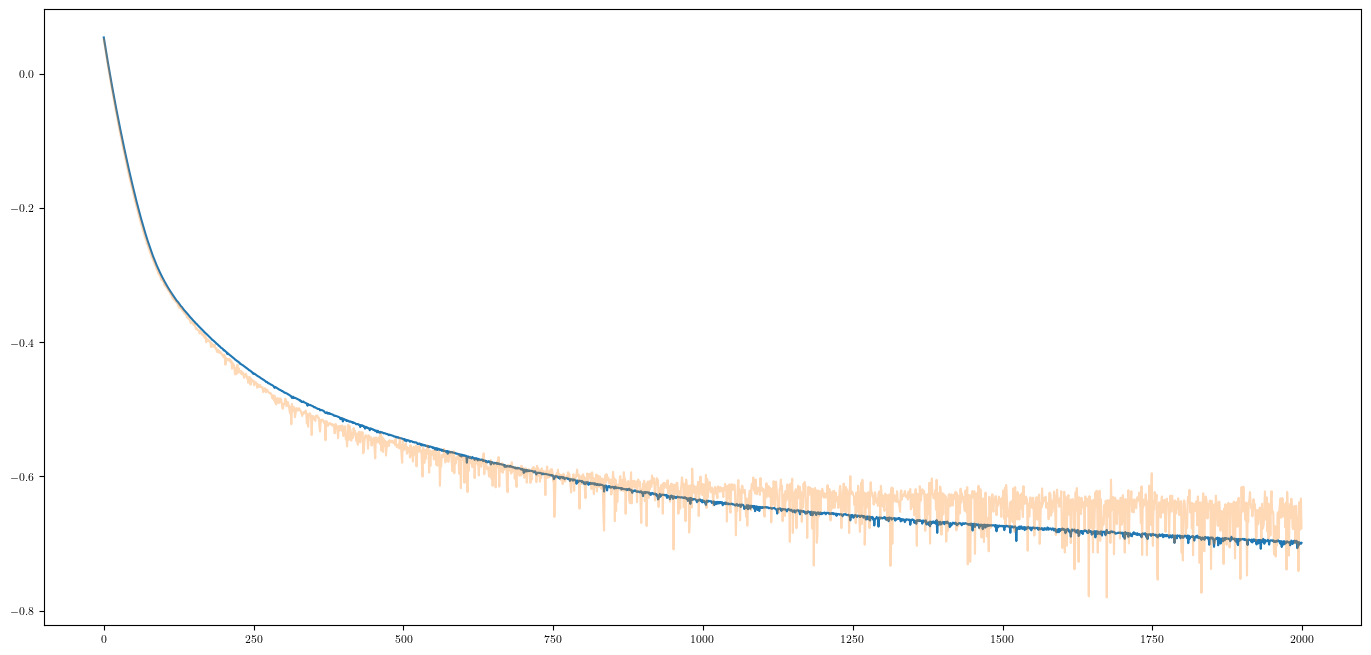

In [30]:
ls = model.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(model.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

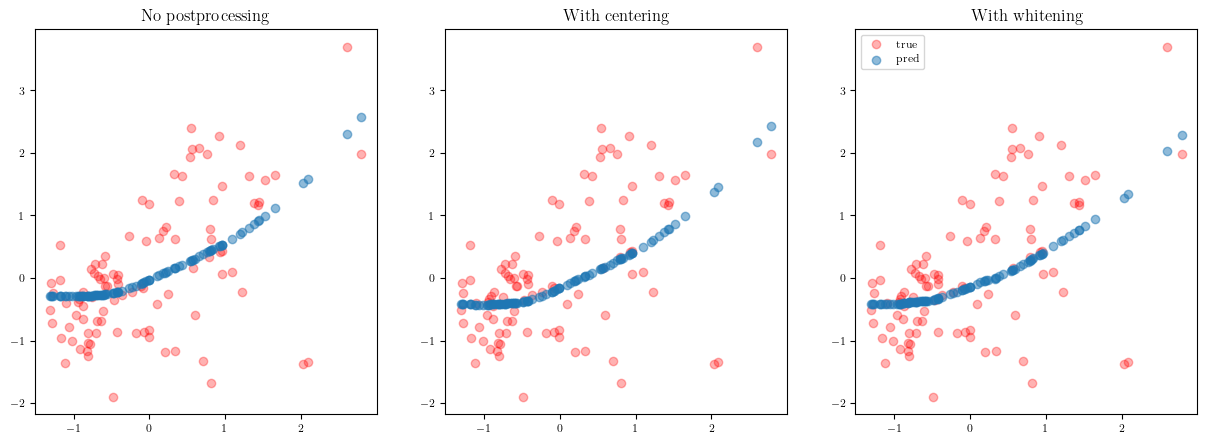

In [31]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = model.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = model.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = model.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

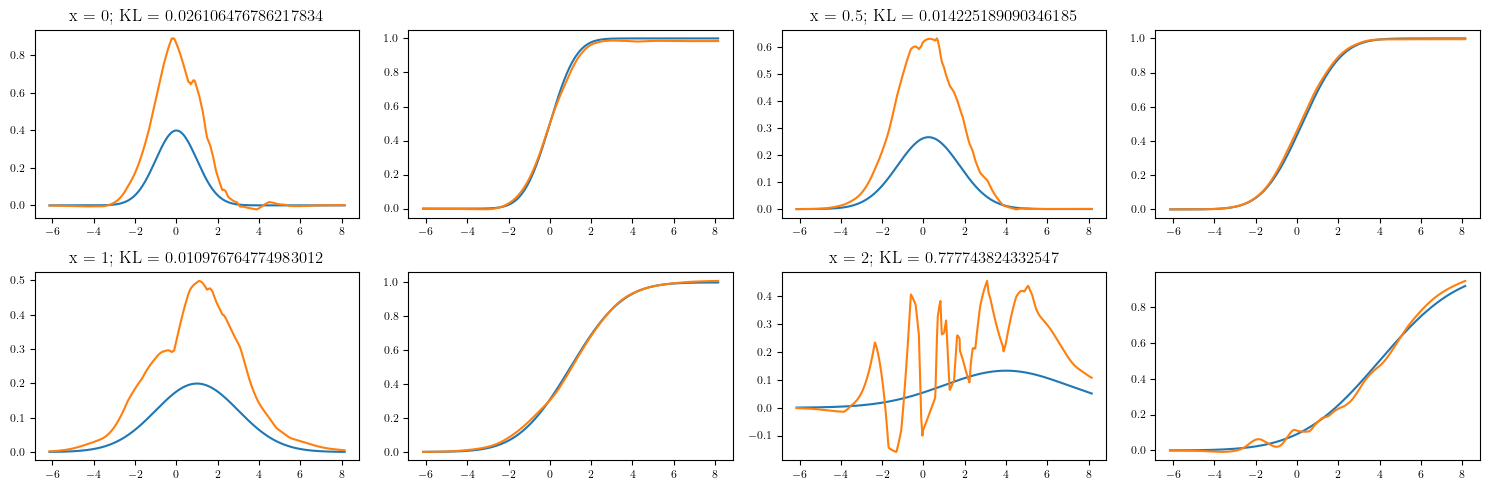

In [32]:
from scipy.stats import norm
from NCP.cdf import get_pdf
from NCP.metrics import *

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = ys.reshape(-1, 1)

p_x = empirical_marginal(bandwidth='scott').fit(X_train)
p_y = empirical_marginal(bandwidth='scott').fit(Y_train)

for i, xi in enumerate([0, 0.5, 1, 2]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = get_pdf(model, x_scaled, ys, postprocess='whitening', p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    # pred_pdf = normalize(pred_pdf)
    # true_pdf = normalize(true_pdf)
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_pdf, pred_pdf)))
    # axes[i*2+1].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_cdf, pred_cdf)))
    
plt.tight_layout()
plt.show()

In [33]:
scores = empirical_KL(model, X_test, np.linspace(-2.5, 2.5, num=100).reshape(-1, 1))

100%|██████████| 100/100 [00:04<00:00, 21.62it/s]


In [34]:
print(np.mean(scores))
print(np.median(scores))

0.02504563907146649
0.00880268426884061


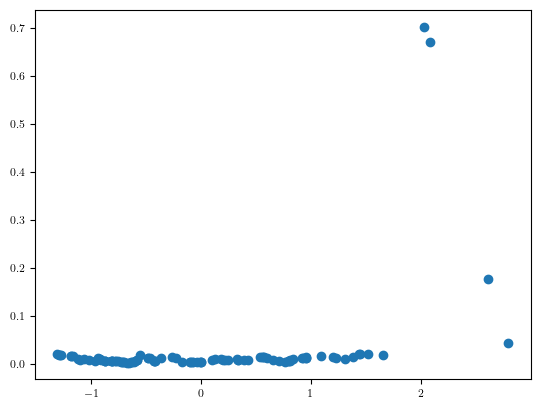

In [35]:
plt.scatter(X_test.squeeze(), np.array(scores))

## ARMA Jump 

In [50]:
density_simulator = ArmaJump(random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = get_pdf(model, x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = density_simulator.pdf(xscaler.inverse_transform(x[..., None]), fys.reshape(1, -1))
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

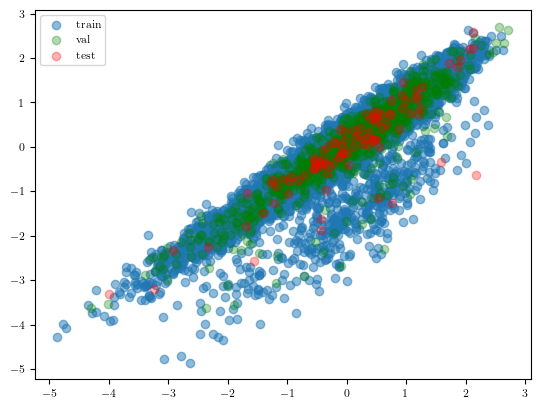

In [37]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [39]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 64,
    'lr': 1e-4,
    'gamma': 1e-3,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)

In [40]:
model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -2.51535964012146: 100%|██████████| 2000/2000 [00:26<00:00, 75.23it/s]  


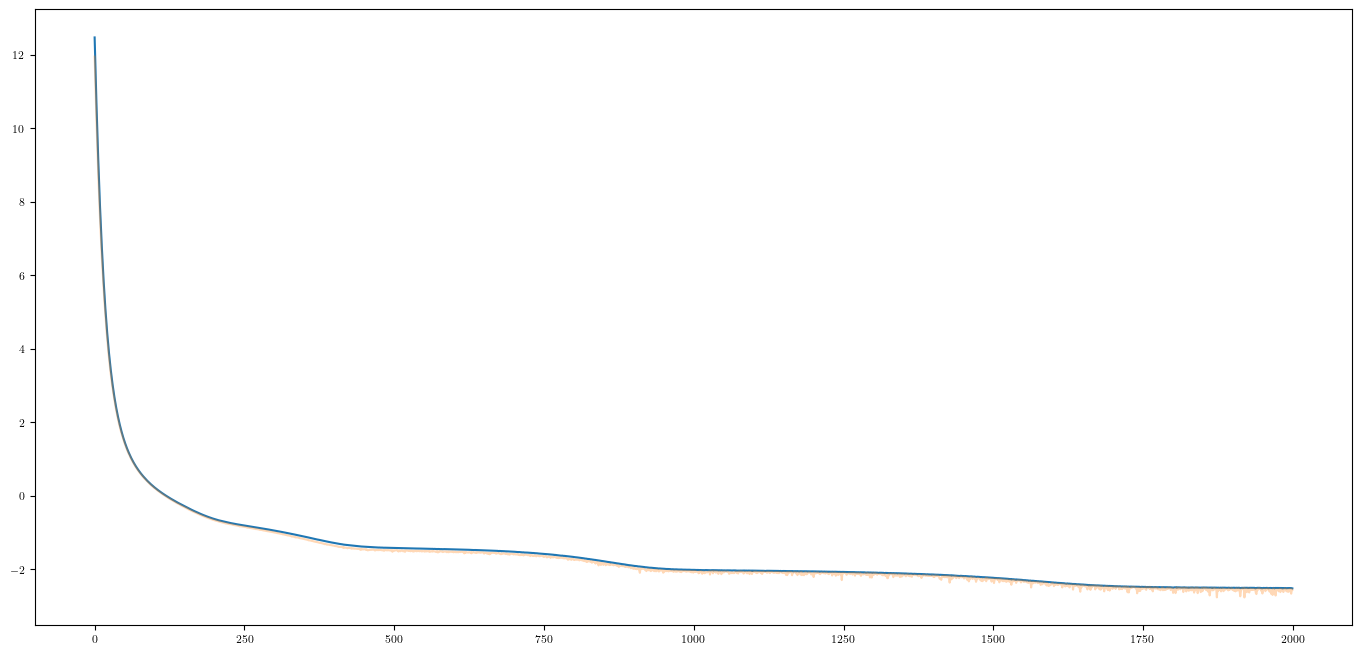

In [41]:
ls = model.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(model.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

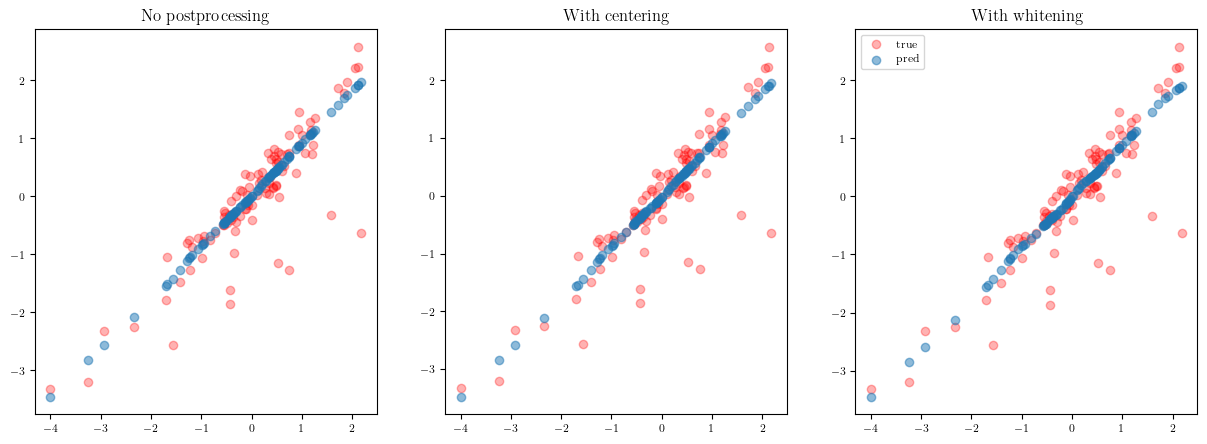

In [42]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = model.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = model.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = model.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

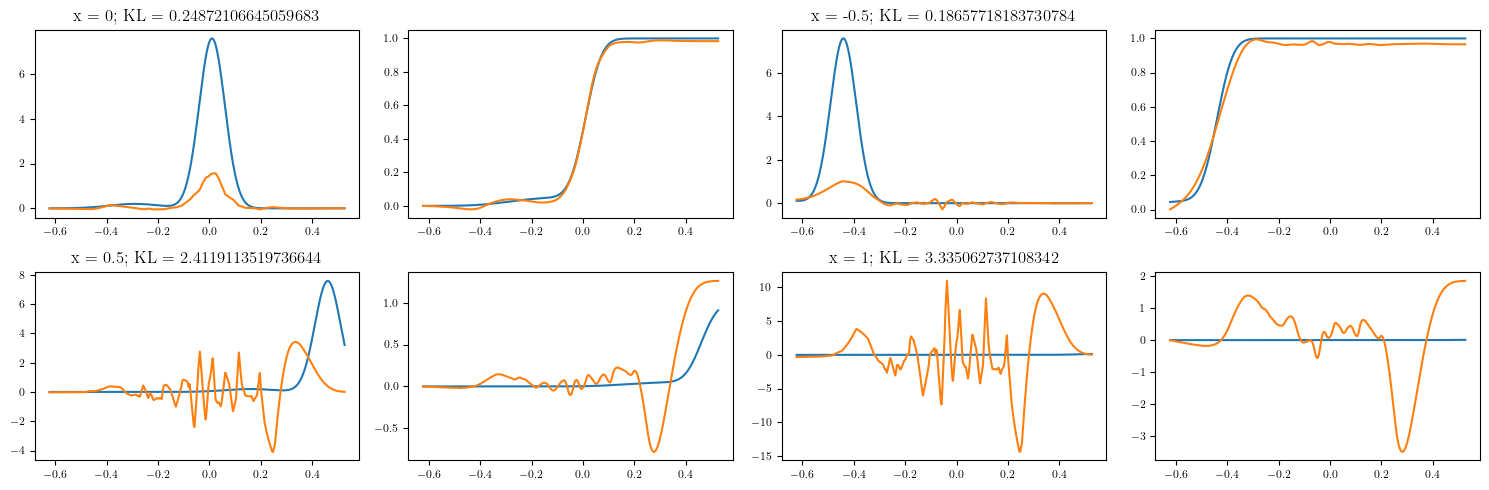

In [47]:
from scipy.stats import norm
from NCP.cdf import get_pdf
from NCP.metrics import *

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = ys.reshape(-1, 1)

p_x = empirical_marginal(bandwidth='scott').fit(X_train)
p_y = empirical_marginal(bandwidth='scott').fit(Y_train)

for i, xi in enumerate([0, -0.5, 0.5, 1]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = get_pdf(model, x_scaled, ys, postprocess='whitening', p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    # pred_pdf = normalize(pred_pdf)
    # true_pdf = normalize(true_pdf)
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_pdf, pred_pdf)))
    # axes[i*2+1].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_cdf, pred_cdf)))
    
plt.tight_layout()
plt.show()

In [51]:
scores = empirical_KL(model, X_test, np.linspace(-2.5, 2.5, num=100).reshape(-1, 1))

100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


In [52]:
print(np.mean(scores))
print(np.median(scores))

0.2833804721686113
0.12423980639803367


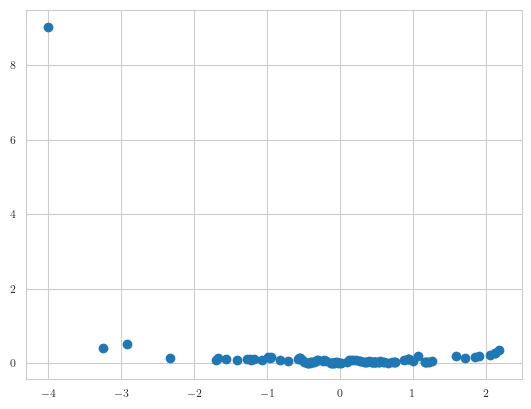

In [127]:
plt.scatter(X_test.squeeze(), np.array(scores))

## SkewNormal

In [53]:
density_simulator = SkewNormal(random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = get_pdf(model, x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = density_simulator.pdf(xscaler.inverse_transform(x[..., None]), fys.reshape(1, -1))
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

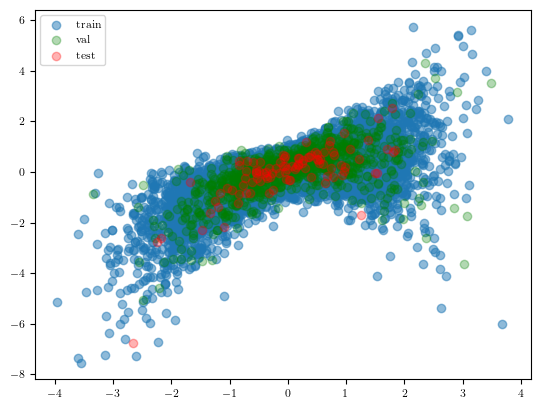

In [54]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [55]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 1,
    'layer_size': 256,
    'lr': 1e-4,
    'gamma': 1e-3,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)

In [56]:
model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -1.130668044090271: 100%|██████████| 2000/2000 [00:25<00:00, 77.42it/s]  


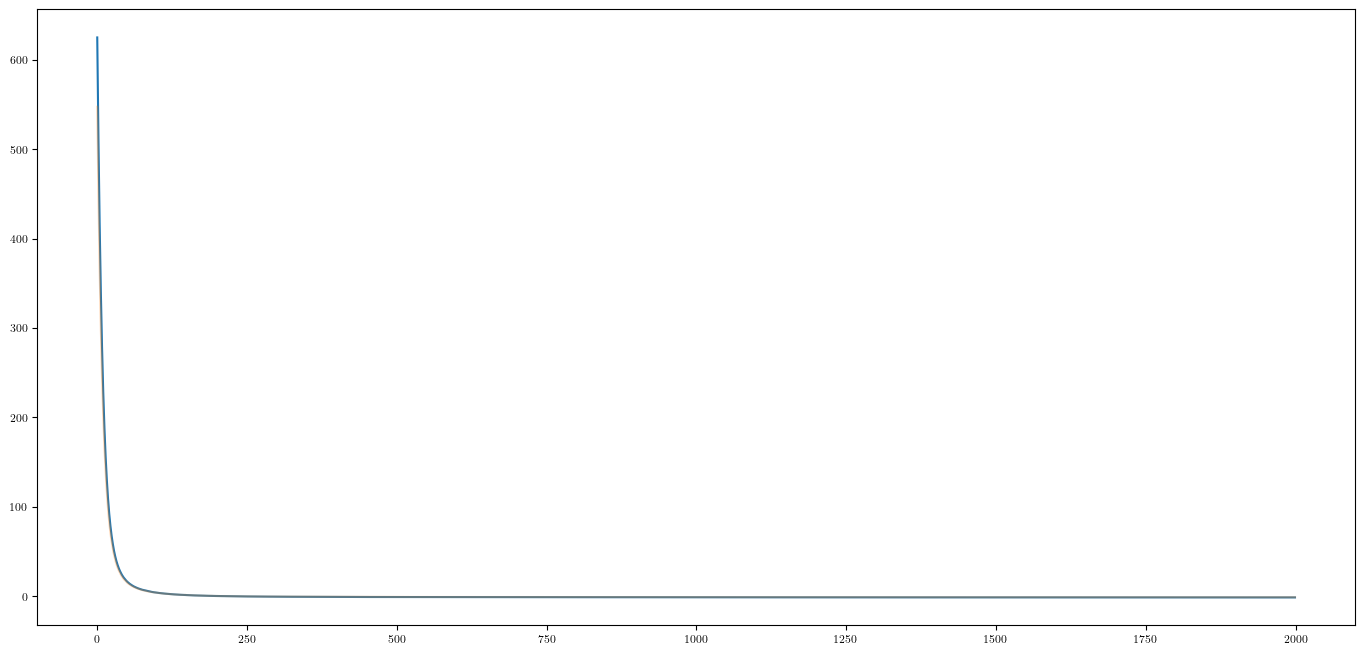

In [57]:
ls = model.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(model.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

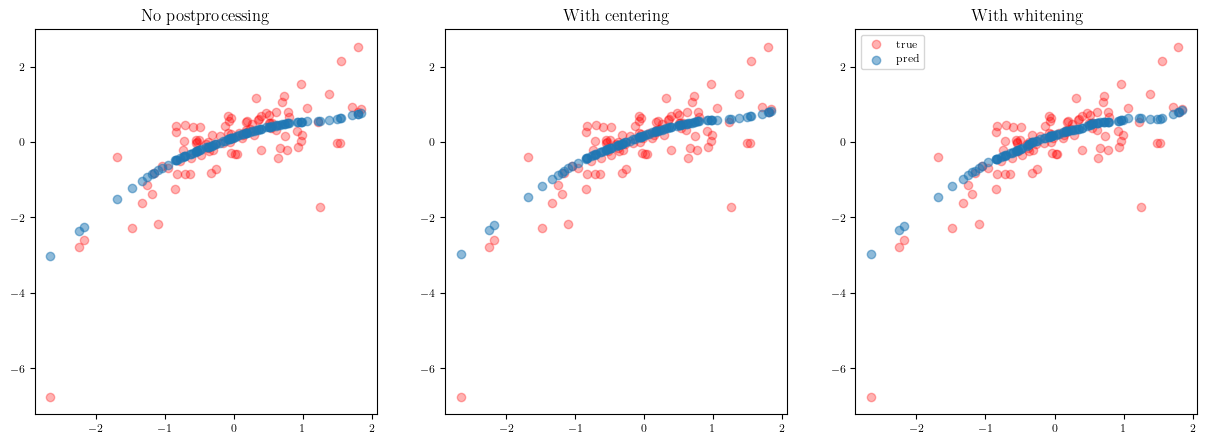

In [58]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = model.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = model.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = model.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

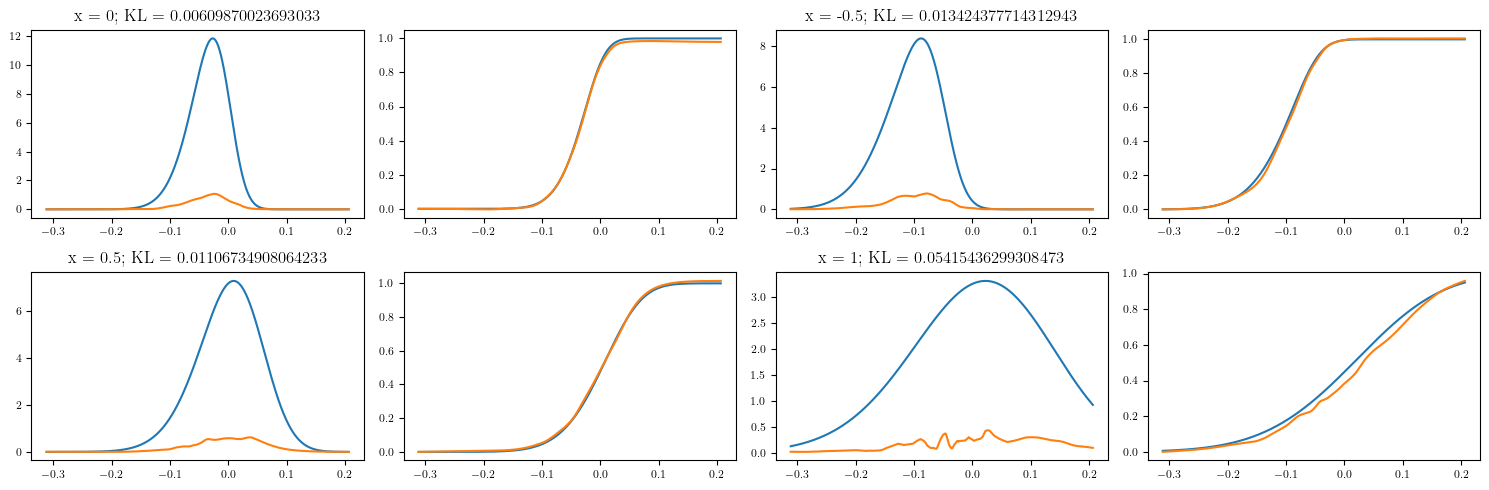

In [61]:
from scipy.stats import norm
from NCP.cdf import get_pdf
from NCP.metrics import *

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()

ys = np.linspace(-3, 3, num=1000).reshape(-1, 1)

p_x = empirical_marginal(bandwidth='scott').fit(X_train)
p_y = empirical_marginal(bandwidth='scott').fit(Y_train)

for i, xi in enumerate([0, -0.5, 0.5, 1]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = get_pdf(model, x_scaled, ys, postprocess='whitening', p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    # pred_pdf = normalize(pred_pdf)
    # true_pdf = normalize(true_pdf)
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_pdf, pred_pdf)))
    # axes[i*2+1].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_cdf, pred_cdf)))
    
plt.tight_layout()
plt.show()

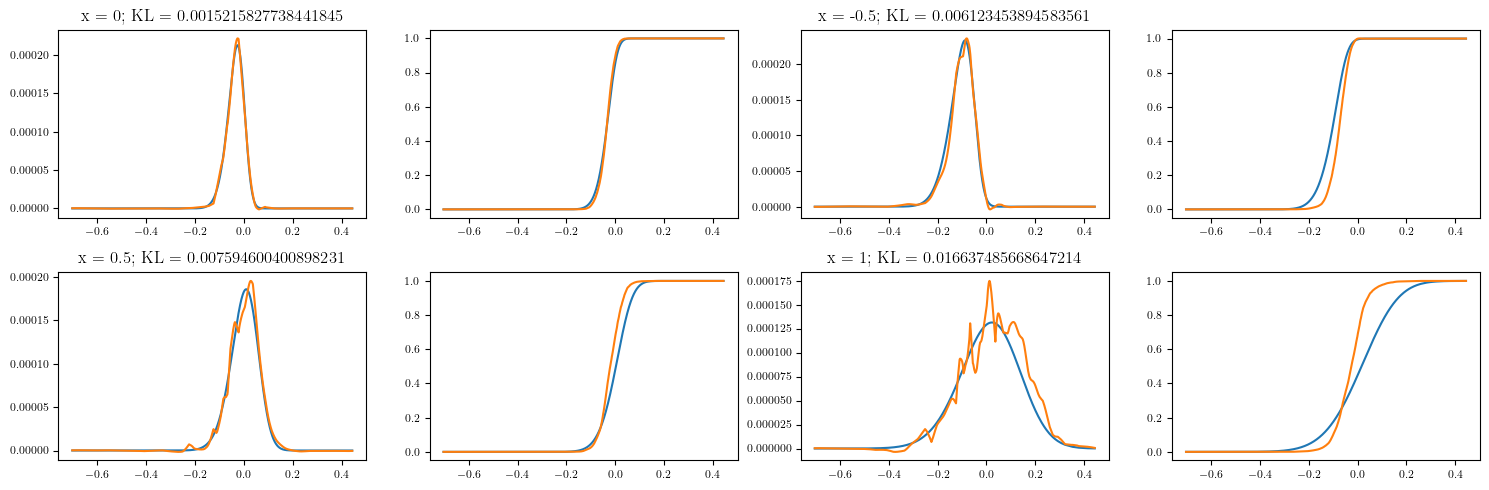

In [15]:
from scipy.stats import norm
from NCP.cdf import get_pdf
from NCP.metrics import *

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()

p_x = empirical_marginal(bandwidth='scott').fit(X_train)
p_y = empirical_marginal(bandwidth='scott').fit(Y_train)

for i, xi in enumerate([0, -0.5, 0.5, 1]):
    x_scaled = xscaler.transform([[xi]])
    fys, pred_pdf = get_pdf(model, x_scaled, postprocess='whitening', p_x=p_x, p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), fys.reshape([1, -1])).squeeze()
    pred_pdf = normalize(pred_pdf)
    true_pdf = normalize(true_pdf)
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf)
    true_cdf = density_simulator.cdf(np.array([[xi]]), fys.reshape([1, -1])).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_pdf, pred_pdf)))
    # axes[i*2+1].set_title(r'x = {0}; KL = {1}'.format(xi, KL(true_cdf, pred_cdf)))

plt.tight_layout()
plt.show()

In [16]:
scores = empirical_KL(model, X_test, np.linspace(-2.5, 2.5, num=100).reshape(-1, 1))

100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


In [17]:
print(np.mean(scores))
print(np.median(scores))

0.023775023410084382
0.015051862462094657


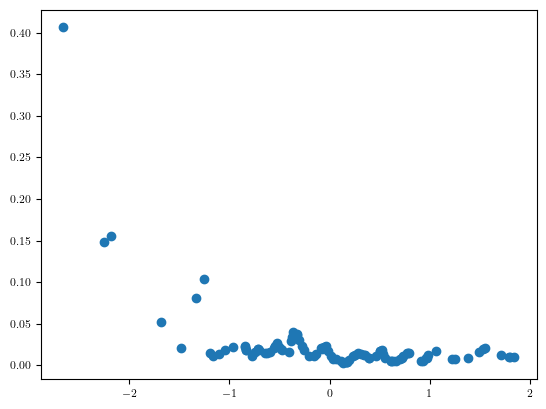

In [18]:
plt.scatter(X_test.squeeze(), np.array(scores))